In [13]:
from keras.models import load_model

model = load_model('/content/drive/MyDrive/All-datasets/cats_and_dogs_small/cats_and_dogs_small_1.h5')

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [15]:
img_path = '/content/drive/MyDrive/All-datasets/cats_and_dogs_small/test/Cat/234.jpg'

# We preprocess the image into a 4D tensor
from keras.preprocessing import image 
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
# Remember that the model was trained on inputs
# that were preprocessed in the following way:
img_tensor /= 255.

# Its shape is (1, 150, 150, 3)
print(img_tensor.shape)

(1, 150, 150, 3)


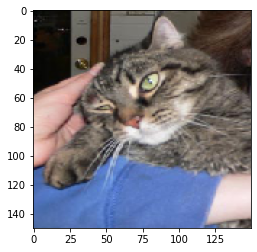

In [16]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

In [17]:
from keras import models

# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [18]:
# This will return a list of 5 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(img_tensor)

In [19]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


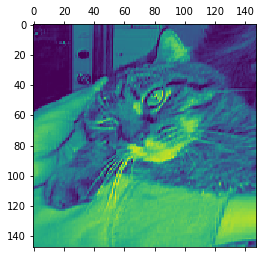

In [20]:
import matplotlib.pyplot as plt 

plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis')
plt.show()

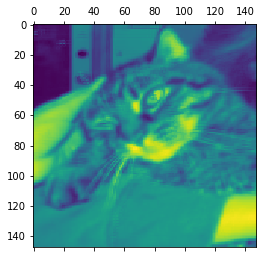

In [21]:
plt.matshow(first_layer_activation[0, :, :, 30], cmap='viridis')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


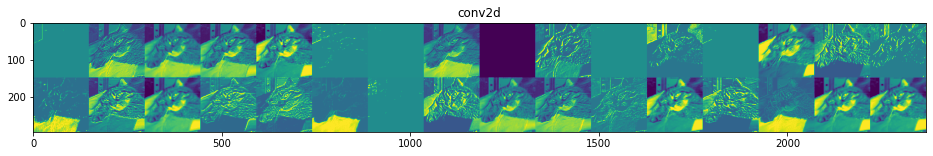

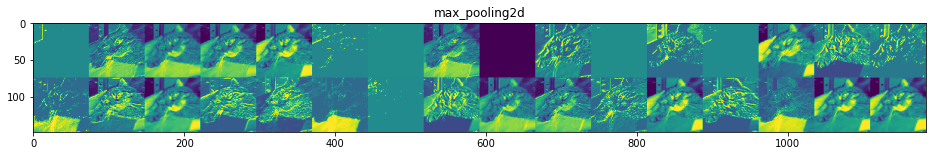

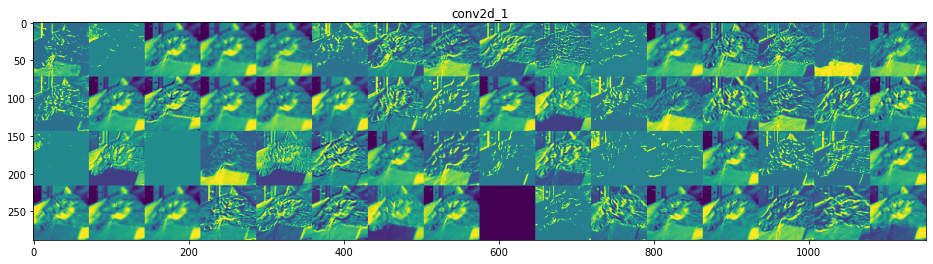

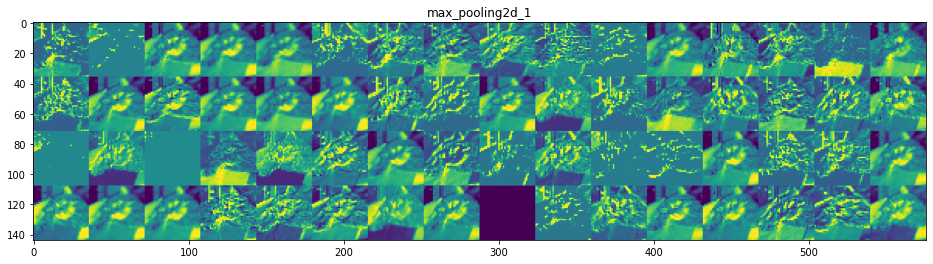

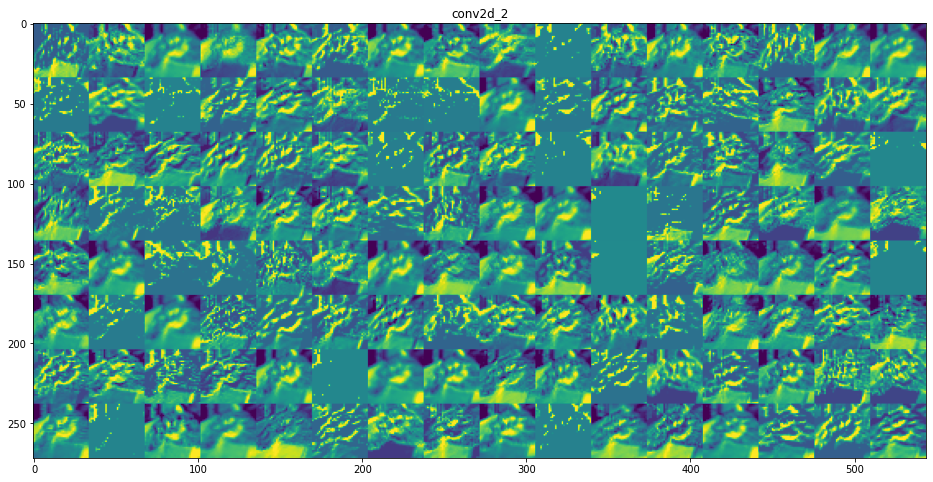

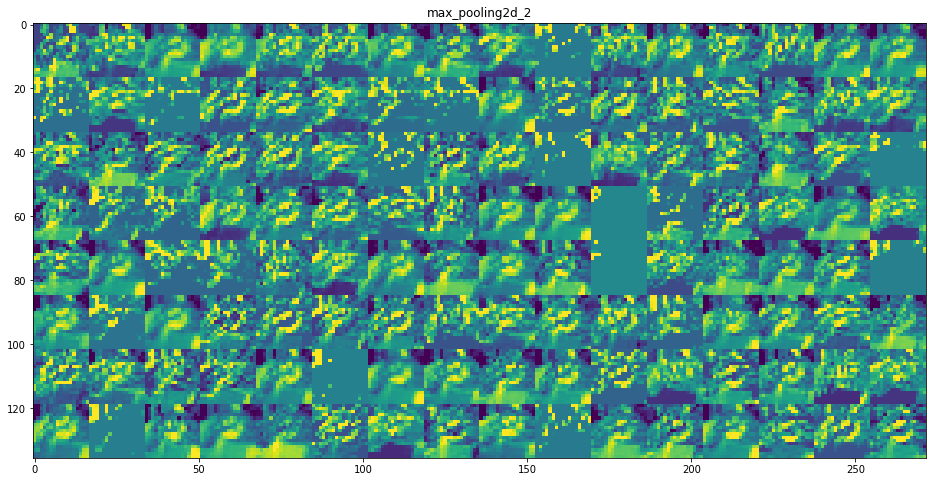

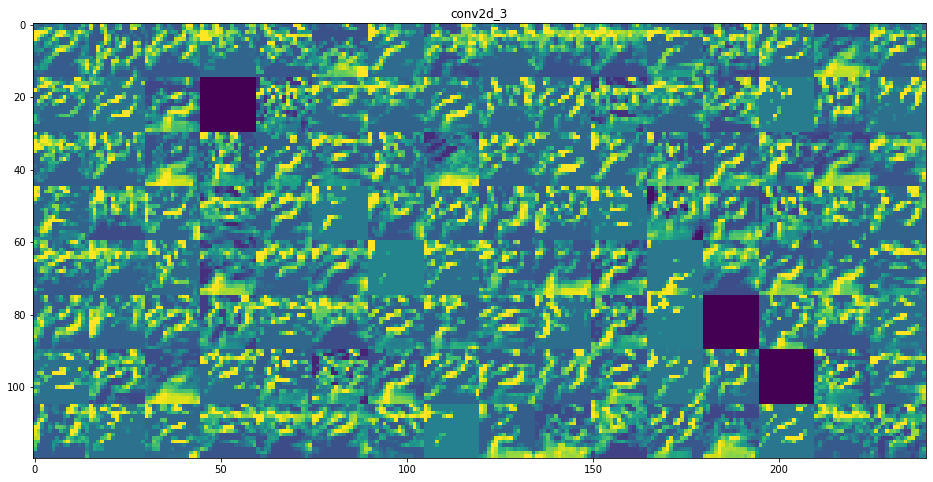

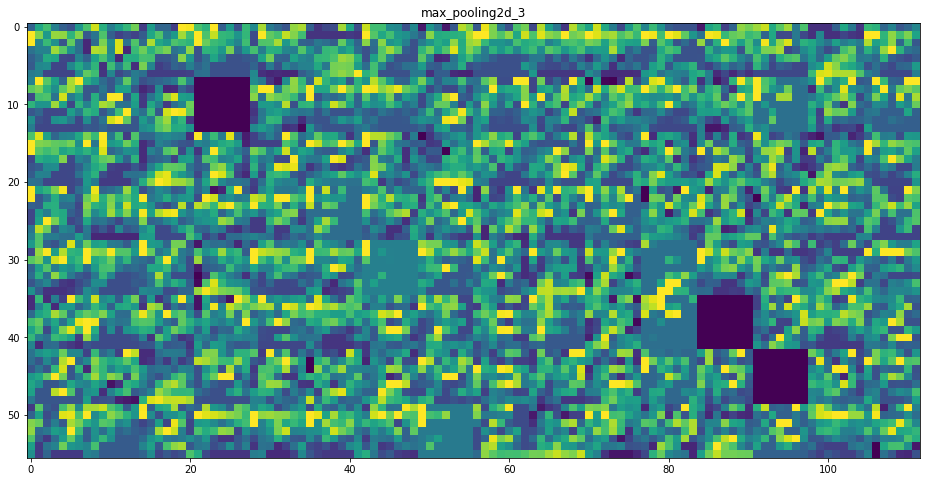

In [26]:
from tensorflow import keras 


# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:8]:
  layer_names.append(layer.name)

images_per_row = 16


# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
  # This is the number of features in the feature map
  n_features = layer_activation.shape[-1]

  # The feature map has shape (1, size, size, n_features)
  size = layer_activation.shape[1]

  # We will tile the activation channels in this matrix
  n_cols = n_features // images_per_row
  display_grid = np.zeros((size * n_cols, images_per_row * size))


  # We'll tile each filter into this big horizontal grid
  for col in range(n_cols):
    for row in range(images_per_row):
      channel_image = layer_activation[0,
                                       :, :,
                                       col * images_per_row + row]

      # Post-process the feature to make it visually palatable
      channel_image -= channel_image.mean()
      channel_image /= channel_image.std()
      channel_image *= 64
      channel_image += 128
      channel_image = np.clip(channel_image, 0, 255).astype('uint8')
      display_grid[col * size : (col + 1) * size,
                   row * size : (row + 1) * size] = channel_image

  # Display the grid
  scale = 1. / size
  plt.figure(figsize=(scale * display_grid.shape[1],
                      scale * display_grid.shape[0]))
  plt.title(layer_name)
  plt.grid(False)
  plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()

In [37]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()


model = VGG16(weights='imagenet',
              include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

grads = K.gradients(loss, model.input)[0]

In [38]:
# We add 1e-5 before dividing so as to avoid accidentally dividing by 0.
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

In [39]:
iterate = k.function([model.input], [loss, grads])

# Let's test it:
import numpy as np 
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

In [40]:
# We start from a gray image with some noise
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

# Run gradient ascent for 40 steps
step = 1.   # this is the magnitude of each gradient update
for i in range(40):
  # Compute the loss value and gradient value
  loss_value, grads_value = iterate([input_img_data])
  # Here we adjust the input image in the direction that maximizes the loss
  input_img_data += grads_value * step

In [41]:
def deprocess_image(x):
  # normalize tensor: center on 0., ensure std is 0.1
  x -= x.mean()
  x /= (x.std() + 1e-5)
  x *= 0.1

  # clip to [0, 1]
  x += 0.5
  x = np.clip(x, 0, 1)

  # convert to RGB array
  x *= 255
  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [42]:
def generate_pattern(layer_name, filter_index, size=150):
  # Build a loss function that maximizes the activation
  # of the nth filter of the layer considered.
  layer_output = model.get_layer(layer_name).output
  loss = k.mean(layer_output[:, :, :, filter_index])

  # Compute the gradient of the input picture wrt this loss
  grads = k.gradients(loss, model.input)[0]

  # Normalization trick: we normalize the gradient
  grads /= (k.sqrt(k.mean(k.square(grads))) + 1e-5)

  # This function returns the loss and grads given the input picture
  iterate = k.function([model.input], [loss, grads])

  # We start from a gray image with some noise
  input_img_data = np.random.random((1, size, size, 3)) * 3 + 128.


  # Run gradient ascent for 40 steps
  step = 1.
  for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step

  img = input_img_data[0]
  return deprocess_image(img)

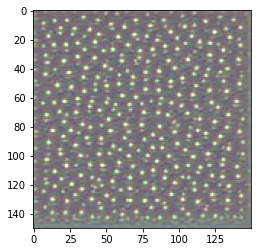

In [43]:
plt.imshow(generate_pattern('block3_conv1', 0))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


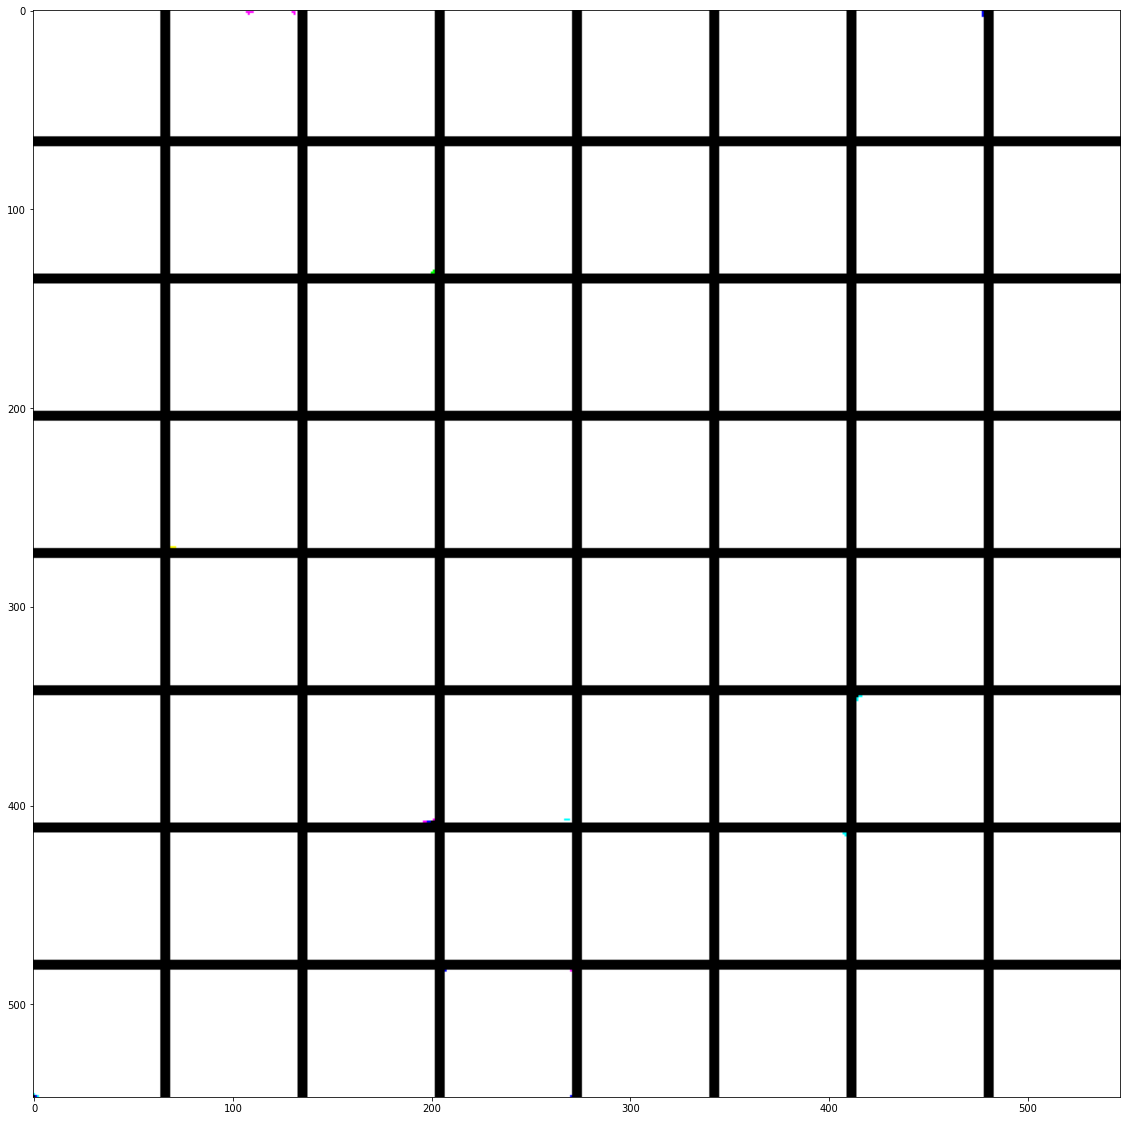

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


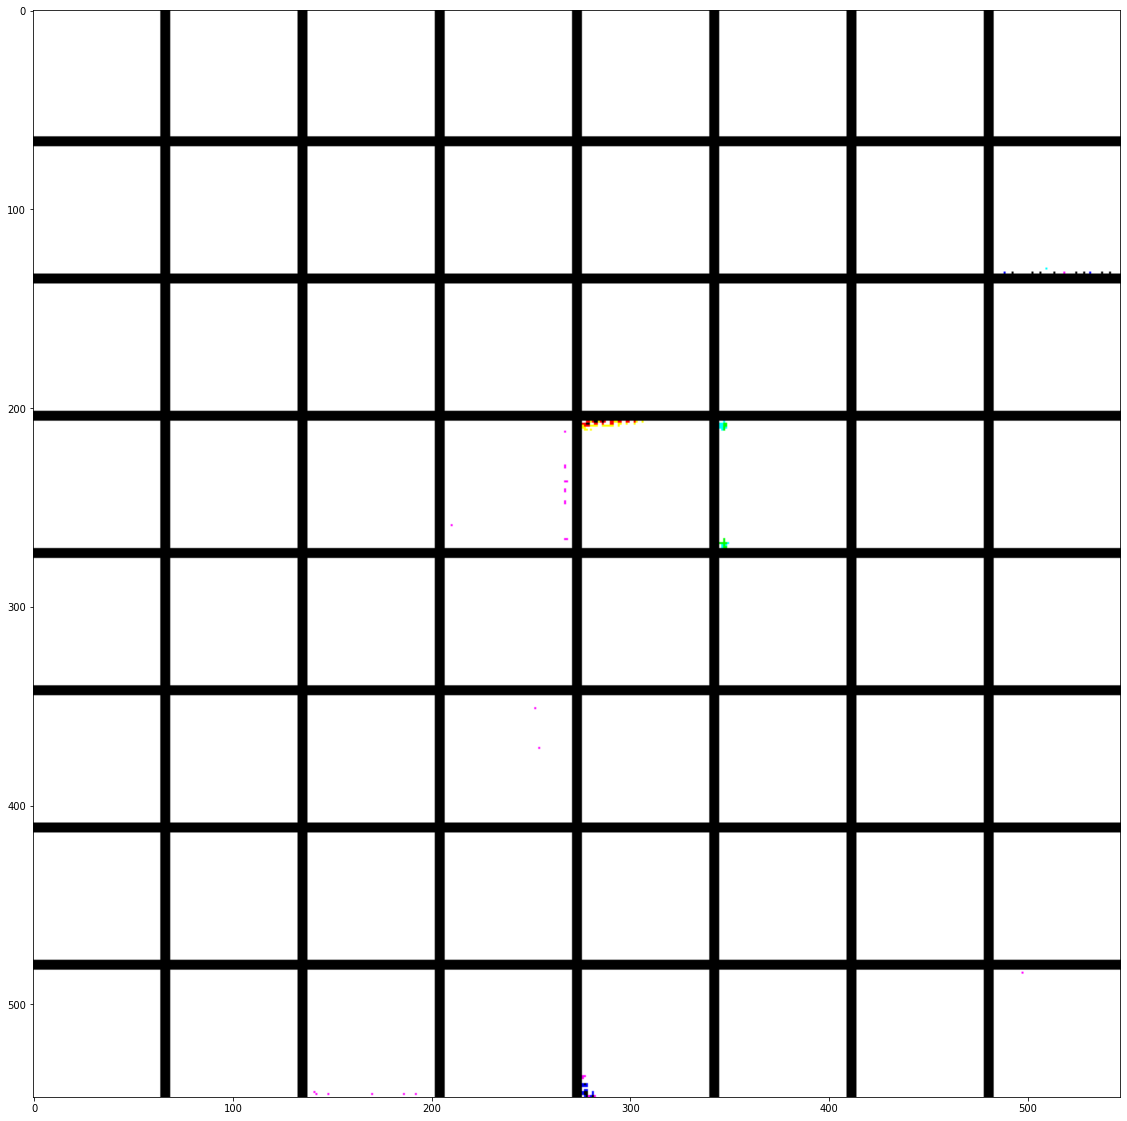

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


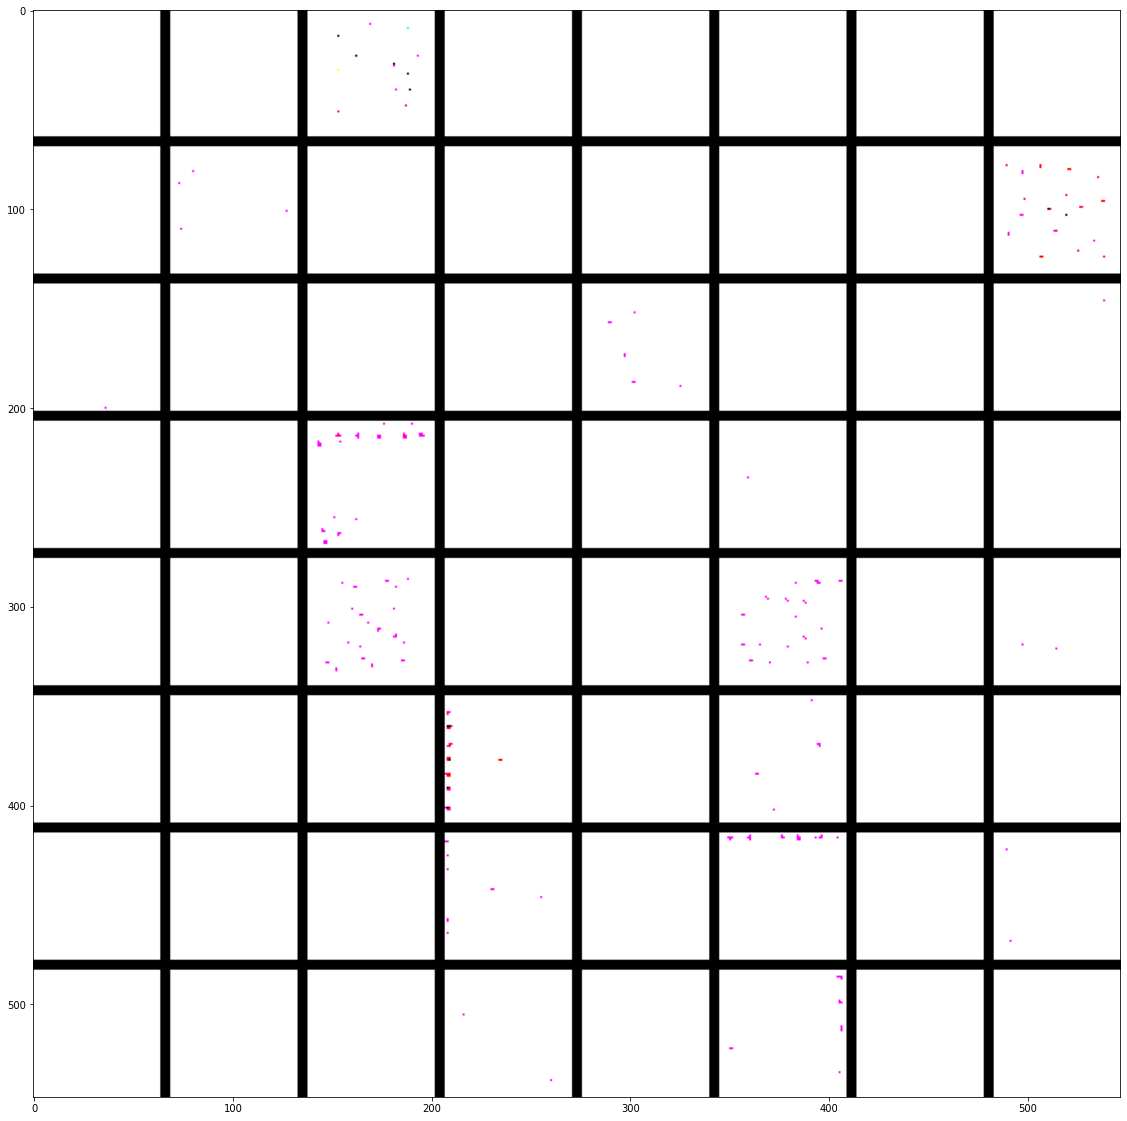

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


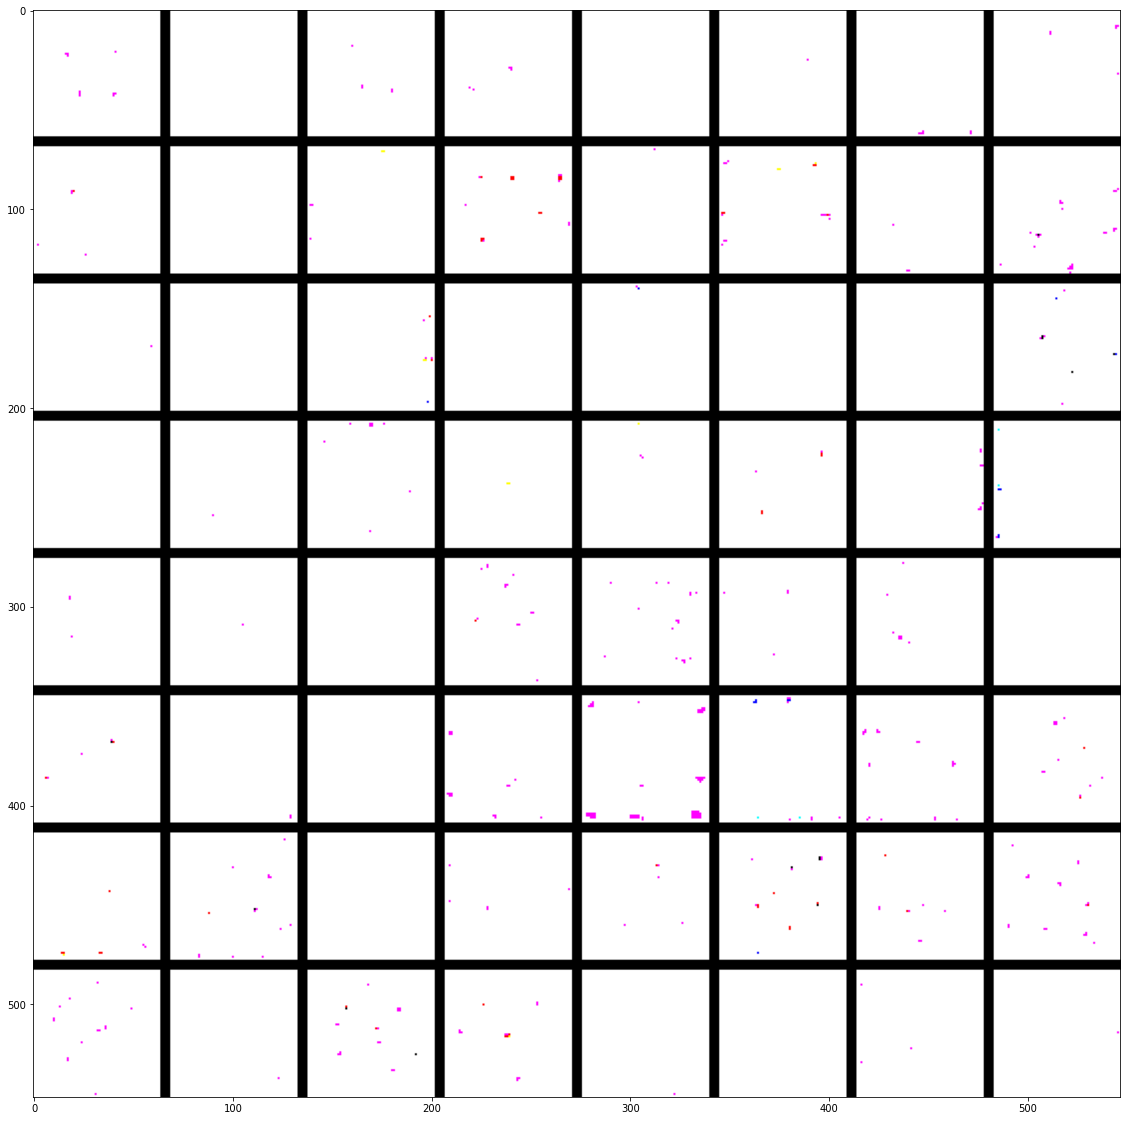

In [44]:
for layer_name in ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1']:
    size = 64
    margin = 5

    # This a empty (black) image where we will store our results.
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    for i in range(8):  # iterate over the rows of our results grid
        for j in range(8):  # iterate over the columns of our results grid
            # Generate the pattern for filter `i + (j * 8)` in `layer_name`
            filter_img = generate_pattern(layer_name, i + (j * 8), size=size)

            # Put the result in the square `(i, j)` of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    # Display the results grid
    plt.figure(figsize=(20, 20))
    plt.imshow(results)
    plt.show()